In [1]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Allow only 1 GPU visible to CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable annoying logs


import tensorflow as tf
from tensorflow.keras import datasets, layers, models , losses
# import simpleaudio as sa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
def _parseme(raw_audio_record):
	feature_description = {
	    'note': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'note_str': tf.io.FixedLenFeature([], tf.string, default_value=''),
	    'instrument': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'instrument_str': tf.io.FixedLenFeature([], tf.string, default_value=''),
	    'pitch': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'velocity': tf.io.FixedLenFeature([], tf.int64,default_value=0),
	    'sample_rate': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'audio': tf.io.FixedLenSequenceFeature([], tf.float32,  allow_missing=True, default_value=0.0),
	    'qualities': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True, default_value=0),
	    'qualities_str': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True, default_value=''),
	    'instrument_family': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'instrument_family_str': tf.io.FixedLenFeature([], tf.string, default_value=''),
	    'instrument_source': tf.io.FixedLenFeature([], tf.int64, default_value=0),
	    'instrument_source_str': tf.io.FixedLenFeature([], tf.string, default_value='')     
	}

	return tf.io.parse_single_example(raw_audio_record, feature_description)



def extract_data(ds_data,input_size,test_size):
  x = []
  y = []
  count = 0
  for element in ds_data:
    count+=1
    if count > test_size:
        break;
    if int(element['instrument_family'].numpy()) == 9:
      continue
    else:
      temp = np.resize(element['audio'][:16000].numpy(),100*160)
      x.append(temp)
#       x.append(np.resize(element['audio'].numpy(),input_size*input_size))
      if int(element['instrument_family'].numpy()) == 10:
        y.append(element['instrument_family'].numpy()-1)
      else :
        y.append(element['instrument_family'].numpy())
   
  x = np.array(x)
  y = np.array(y)
  return x,y

In [3]:
test_raw_data = tf.data.TFRecordDataset("/local/sandbox/nsynth-tf/nsynth-test.tfrecord")

In [4]:
input_size = 16000
test_size = 22679
test_ar = test_raw_data.map(_parseme)
x,y = extract_data(test_ar,input_size,test_size)
x = np.expand_dims(x,axis=-1)

In [5]:
complex_network_Model=load_model('project2_BLSTM_network.h5')
complex_network_Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15841, 32)         5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3960, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               33200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [6]:
result =  complex_network_Model.evaluate(x, y)

128/128 [==============================] - 22s 148ms/step - loss: 1.4251 - accuracy: 0.4917


In [7]:
prediction = complex_network_Model.predict(x[:,:])

In [8]:
# print(x.shape)
# print(y.shape)
# x_rechange = []
# for i in x:    
#     tmp = i[:,:,0]
#     tmp = tmp.flatten()
#     x_rechange.append(tmp)

# x_rechange = np.array(x_rechange)
# print(x_rechange.shape)
# x = x_rechange

In [9]:
print(prediction[0])
print(y[0])
print(len(y))
print(len(prediction))

[4.5604160e-01 6.7648325e-06 5.0920159e-02 1.2365348e-01 2.1720441e-01
 1.0791654e-01 1.9074850e-02 7.7829272e-03 1.1101579e-03 1.6289184e-02]
0
4096
4096


[0.49170616113744076, 0.36666666666666664, 0.3867403314917127, 0.19142419601837674, 0.6805736636245111, 0.4433497536945813, 0.6461232604373758, 0.2457627118644068, 0.6449511400651465, 0.7887323943661971]
[0.49170616113744076, 0.36666666666666664, 0.3867403314917127, 0.19142419601837674, 0.6805736636245111, 0.4433497536945813, 0.6461232604373758, 0.2457627118644068, 0.6449511400651465, 0.7887323943661971]


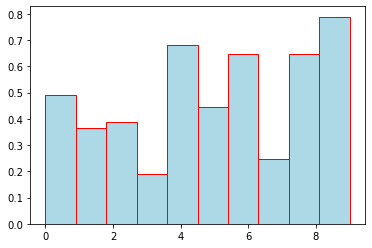

<Figure size 432x288 with 0 Axes>

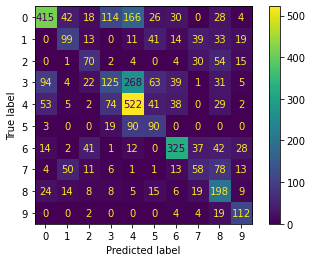

<Figure size 432x288 with 0 Axes>

In [10]:
true_table = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
miss_classified = []
prediciton_by_class = []
right_classified = []
for i in range(len(prediction)):
    prediciton_by_class.append(np.argmax(prediction[i]))
    if y[i] == np.argmax(prediction[i]):
        true_table[y[i]][0]+=1
        right_classified.append([y[i],prediction[i],x[i],0])
    else :
        miss_classified.append([y[i],np.argmax(prediction[i])])
        true_table[y[i]][1]+=1


accuracy_set = []
for i in range(len(true_table)):
    right = true_table[i][0]
    wrong = true_table[i][1]
    accuracy = right/(right+wrong+1)
    accuracy_set.append(accuracy)
print(accuracy_set)
data = [0,1,2,3,4,5,6,7,8,9]
plt.hist(data,weights= accuracy_set,color = 'lightblue',ec="red")
plt.savefig('project2_BLSTM_histogram.png')
plt.figure().clear()
print(accuracy_set)
disp = ConfusionMatrixDisplay(confusion_matrix(y, prediciton_by_class, labels=[i for i in range(10)]))
disp.plot()
plt.savefig('project2_BLSTM_confusionmatrix.png')
plt.figure().clear()

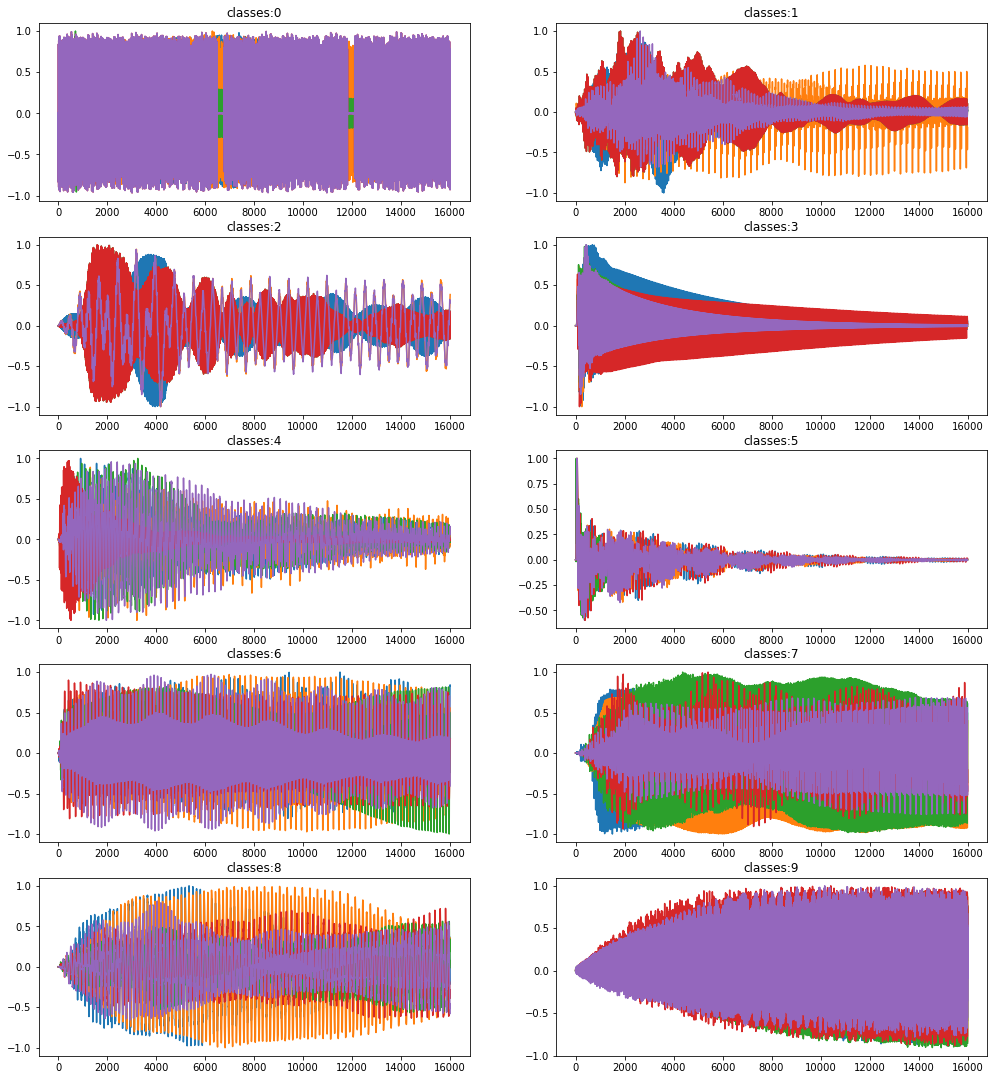

<Figure size 432x288 with 0 Axes>

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(17, 19))
visited = []
for i in right_classified:
    visited.append( [i[1].max(),i[0],i[2]] )
visited = sorted(visited, key=lambda test: test[0],reverse=True)


for clas in range(0,10):
    r = clas // 2
    c = clas % 2
    ax = axes[r][c]
    count = 0
    for i in visited:
        if i[1] == clas:
          if count < 5:
            count+=1
            ax.plot(i[2])
            ax.set_title('classes:'+str(clas))
plt.show()
plt.savefig('project2_BLSTM_high_prob_waveform.png')

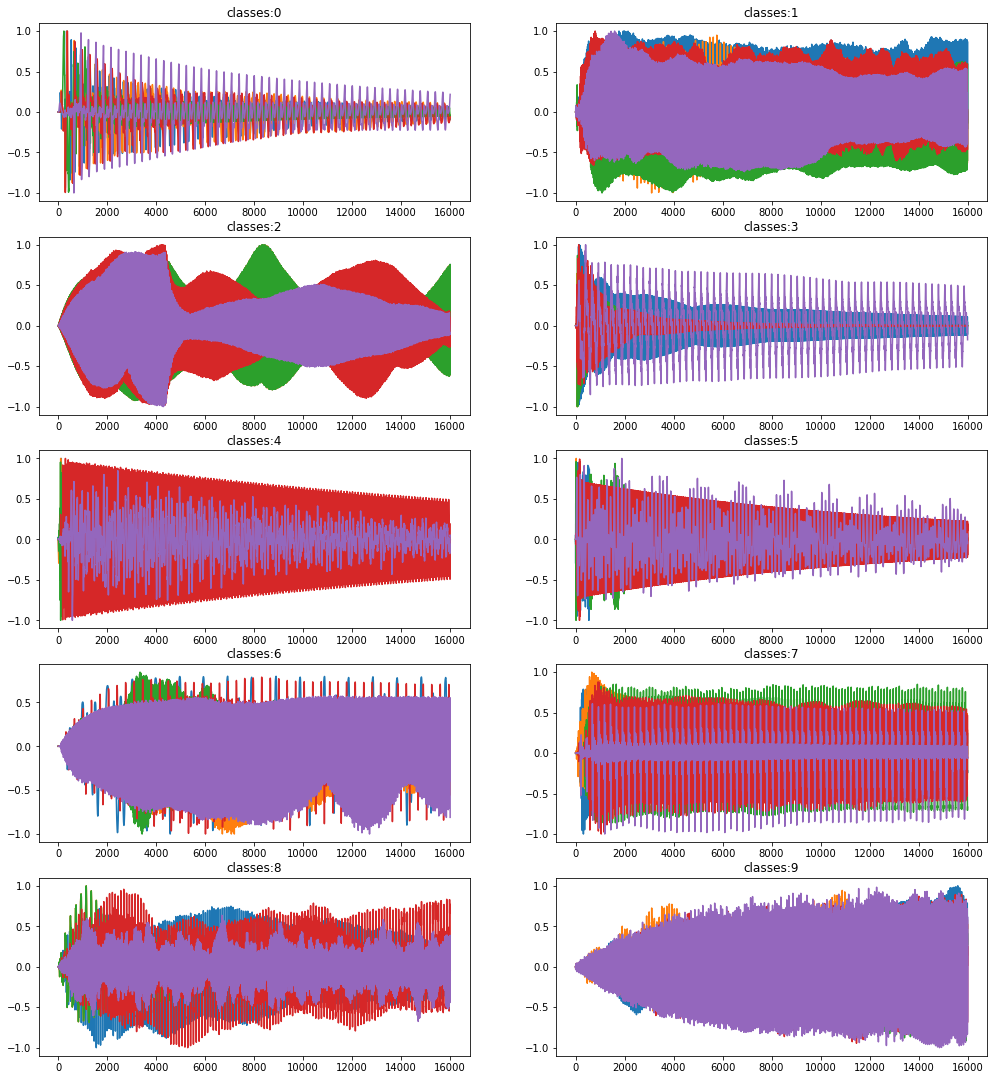

<Figure size 432x288 with 0 Axes>

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(17, 19))
visited = []
for i in right_classified:
    visited.append( [i[1].max(),i[0],i[2]] )
visited = sorted(visited, key=lambda test: test[0])

for clas in range(0,10):
    r = clas // 2
    c = clas % 2
    ax = axes[r][c]
    count = 0
    for i in visited:
        if i[1] == clas:
          if count < 5:
            count+=1
            ax.plot(i[2])
            ax.set_title('classes:'+str(clas))
plt.show()
plt.savefig('project2_BLSTM_low_prob_waveform.png')